Installing Libraries

In [ ]:
%pip  install keras
%pip install sklearn
%pip install numpy
%pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text classification using Deep Neural Networks

In [ ]:
# Import required libraries
from sklearn.datasets import fetch_20newsgroups
from keras.layers import  Dropout, Dense
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, matthews_corrcoef, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import matthews_corrcoef
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

Loading Data

In [ ]:
# import the fetch_20newsgroups function from the sklearn.datasets module
from sklearn.datasets import fetch_20newsgroups

# fetch the 20 newsgroups dataset with 'train' and 'test' subsets
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [ ]:
# create a dictionary with 'text' and 'label' keys for train data and convert it to a DataFrame
data_train = {'text': newsgroups_train.data, 'label': [newsgroups_train.target_names[i] for i in newsgroups_train.target]}
df_train = pd.DataFrame(data_train)

# save train data as a CSV file
df_train.to_csv('newsgroups_train.csv', index=False)

# create a dictionary with 'text' and 'label' keys for test data and convert it to a DataFrame
data_test = {'text': newsgroups_test.data, 'label': [newsgroups_test.target_names[i] for i in newsgroups_test.target]}
df_test = pd.DataFrame(data_test)

# save test data as a CSV file
df_test.to_csv('newsgroups_test.csv', index=False)

Exploratory Data Analysis

In [ ]:
# Displays the first 5 rows of the dataframe
df_train.head() 

,text,label
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,sci.space


In [ ]:
# Provides information about the dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   label   11314 non-null  object
dtypes: object(2)
memory usage: 176.9+ KB


In [ ]:
# Displays the shape of the DataFrame
df_train.shape

(11314, 2)

In [ ]:
# Displays the sum of null values in each column of the DataFrame
df_train.isnull().sum()

text     0
label    0
dtype: int64

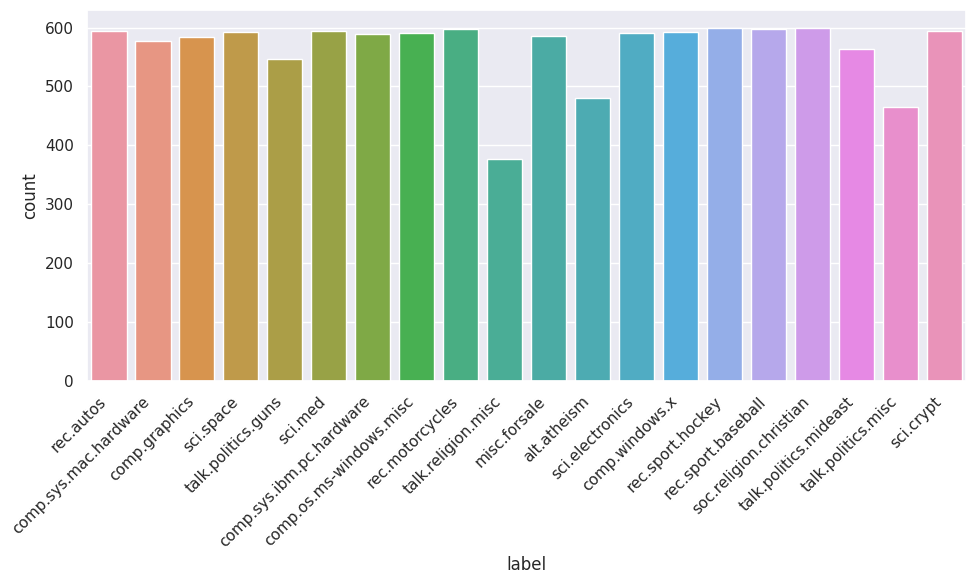

In [ ]:
# Plots the distribution of documents in each category of the training dataset.
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 6)) # set figure size
sns.countplot(x='label', data=df_train, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right") # rotate x-axis labels
plt.tight_layout() # adjust plot layout
plt.show()

In [ ]:
# prints the count of each unique value in the 'label' column of the DataFrame
print(df_train['label'].value_counts())

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: label, dtype: int64


In [ ]:
# import LabelEncoder from sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
encoder = LabelEncoder()

# create Series objects for labels in train and test data
labels_train = df_train['label']
labels_test = df_test['label']

# fit the encoder to the train labels and transform the train and test labels to numerical values
encoded_labels_train = encoder.fit_transform(labels_train)
encoded_labels_test = encoder.fit_transform(labels_test)

# create new columns in train and test data DataFrames to store the encoded labels
df_train['encoded_label'] = encoded_labels_train
df_test['encoded_label'] = encoded_labels_test

# check the unique values of the 'encoded_label' column in train data DataFrame
df_train['encoded_label'].unique()

array([ 7,  4,  1, 14, 16, 13,  3,  2,  8, 19,  6,  0, 12,  5, 10,  9, 15,
       17, 18, 11])

Pre-Processing

In [ ]:
# import necessary libraries for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

# define a function to filter stop words and perform lemmatization
def preprocess_text(text):
  # convert text to lowercase
  text = text.lower() 

  # remove URLs
  text = re.sub(r'http\S+|www.\S+', '', text)

  # tokenize text into words
  words = nltk.word_tokenize(text)

  # remove stop words
  stop_words = set(stopwords.words('english'))
  words = [word for word in words if word not in stop_words]

  # lemmatize words
  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word) for word in words]

  # join the preprocessed words back into a string
  preprocessed_text = ' '.join(words)
  return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# apply preprocess_text function to 'text' column of train data
df_train['format_text'] = df_train['text'].apply(preprocess_text)

# apply preprocess_text function to 'text' column of test data
df_test['format_text'] = df_test['text'].apply(preprocess_text)

# display first few rows of the train data
df_train.head()

,text,label,encoded_label,format_text
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,rec.autos,7,: lerxst @ wam.umd.edu ( 's thing ) subject : ...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,comp.sys.mac.hardware,4,: guykuo @ carson.u.washington.edu ( guy kuo )...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,comp.sys.mac.hardware,4,: twillis @ ec.ecn.purdue.edu ( thomas e willi...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,comp.graphics,1,: jgreen @ amber ( joe green ) subject : : wei...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,sci.space,14,: jcm @ head-cfa.harvard.edu ( jonathan mcdowe...


Machine Learning Models

In [ ]:
X_train = df_train['format_text'] # preprocessed train texts
X_test = df_test['format_text'] # preprocessed test texts
y_train = df_train['encoded_label'] # encoded train labels
y_test = df_test['encoded_label'] # encoded test labels

In [ ]:
def evaluate_classification(y_true, y_pred):
    """
    Evaluate classification performance and return various metrics.

    Args:
        y_true (numpy.ndarray): Ground truth labels.
        y_pred (numpy.ndarray): Predicted labels.

    """

    # Calculate the overall accuracy score
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate the Matthews correlation coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)

    # Calculate macro-averaged precision, recall, and F1 score
    macro_precision, macro_recall, macro_f1, _ = score(y_true, y_pred, average='macro')

    # Calculate micro-averaged precision, recall, and F1 score
    micro_precision, micro_recall, micro_f1, _ = score(y_true, y_pred, average='micro')

    # Create a dictionary to store the evaluation metrics
    metrics = {
        'accuracy': accuracy,
        'mcc': mcc,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1': micro_f1
    }

    # Print out the evaluation metrics
    print("Evaluation Metrics:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.capitalize()}: {metric_value:.4f}")

In [ ]:
# Initialize the CountVectorizer object
vectorizer = CountVectorizer()

# Convert the text data into vectors
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

Multinomial Naive Bayes

In [ ]:
# Initialize the Multinomial Naive Bayes classifier object
classifier = MultinomialNB()

# Train the classifier on the vectorized training data
classifier.fit(X_train_vectors, y_train)

# Use the trained classifier to make predictions on the test data
y_pred = classifier.predict(X_test_vectors)

# Print the classification report
print("Multinomial Naive Bayes")
print(classification_report(y_test, y_pred))

Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       319
           1       0.64      0.79      0.71       389
           2       0.56      0.01      0.02       394
           3       0.57      0.80      0.67       392
           4       0.83      0.80      0.82       385
           5       0.67      0.84      0.75       395
           6       0.91      0.72      0.80       390
           7       0.87      0.90      0.89       396
           8       0.96      0.95      0.95       398
           9       0.97      0.91      0.94       397
          10       0.92      0.97      0.94       399
          11       0.76      0.95      0.85       396
          12       0.79      0.70      0.74       393
          13       0.87      0.84      0.86       396
          14       0.83      0.92      0.87       394
          15       0.80      0.95      0.87       398
          16       0.71      0.93      0.80       364
   

In [ ]:
print("Multinomial Naive Bayes")
evaluate_classification(y_test, y_pred)

Multinomial Naive Bayes
accuracy is 0.7979288369622942
MCC: 0.7889440767685992
Macro-Averaging Metrics:
Accuracy: 0.80
Precision: 0.80
Recall: 0.79
F1 Score: 0.77

Micro-Averaging Metrics:
Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1 Score: 0.80


Logistic Regression

In [ ]:
# Initialize the Logistic Regression classifier and fit on the training data
classifier = LogisticRegression()
classifier.fit(X_train_vectors, y_train)

# Predict the labels for the test data
y_pred = classifier.predict(X_test_vectors)

# Print the classification report containing various metrics like precision, recall, f1-score, and support for each class as well as their average.
print("Logistic Regression")
print(classification_report(y_test, y_pred))

Logistic Regression
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       319
           1       0.68      0.76      0.72       389
           2       0.74      0.67      0.70       394
           3       0.66      0.70      0.68       392
           4       0.77      0.83      0.80       385
           5       0.83      0.71      0.77       395
           6       0.78      0.88      0.83       390
           7       0.87      0.85      0.86       396
           8       0.92      0.92      0.92       398
           9       0.86      0.91      0.89       397
          10       0.93      0.93      0.93       399
          11       0.94      0.88      0.91       396
          12       0.68      0.74      0.71       393
          13       0.88      0.78      0.83       396
          14       0.92      0.90      0.91       394
          15       0.84      0.92      0.88       398
          16       0.71      0.85      0.78       364
       

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("Logistic Regression")
evaluate_classification(y_test, y_pred)

Logistic Regression
accuracy is 0.8044344131704726
MCC: 0.7942385311369694
Macro-Averaging Metrics:
Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1 Score: 0.80

Micro-Averaging Metrics:
Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1 Score: 0.80


Random Forest

In [ ]:
# Initialize Random Forest Classifier with 100 trees and set random state
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier on training data
classifier.fit(X_train_vectors, y_train)

# Predict labels for test data using the trained classifier
y_pred = classifier.predict(X_test_vectors)

# Print classification report for Random Forest Classifier
print("Random Forest")
print(classification_report(y_test, y_pred))

Random Forest
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       319
           1       0.61      0.72      0.66       389
           2       0.65      0.77      0.70       394
           3       0.67      0.71      0.69       392
           4       0.79      0.79      0.79       385
           5       0.80      0.69      0.74       395
           6       0.75      0.90      0.82       390
           7       0.85      0.84      0.85       396
           8       0.91      0.91      0.91       398
           9       0.85      0.92      0.88       397
          10       0.90      0.92      0.91       399
          11       0.89      0.91      0.90       396
          12       0.77      0.57      0.65       393
          13       0.86      0.72      0.79       396
          14       0.86      0.89      0.87       394
          15       0.71      0.96      0.81       398
          16       0.68      0.89      0.77       364
          17 

In [ ]:
print("Random Forest")
evaluate_classification(y_test, y_pred)

Random Forest
accuracy is 0.7841210833775889
MCC: 0.7732696470898931
Macro-Averaging Metrics:
Accuracy: 0.78
Precision: 0.79
Recall: 0.77
F1 Score: 0.77

Micro-Averaging Metrics:
Accuracy: 0.78
Precision: 0.78
Recall: 0.78
F1 Score: 0.78
Weighted Metrics:
Precision: 0.79
Recall: 0.78
F1 Score: 0.78


K-Nearest Neighbor

In [ ]:
# Create a pipeline that preprocesses the text data by applying CountVectorizer and TfidfTransformer,
# and trains a K-Nearest Neighbor classifier on the preprocessed data
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier()),
                     ])

# Fit the pipeline on the training data
text_clf.fit(X_train, y_train)

# Use the trained classifier to predict the labels for the test data
y_pred = text_clf.predict(X_test)

# Print the classification report, which includes precision, recall, F1-score, and support for each class
print("K-Nearest Neighbor")
print(metrics.classification_report(y_test, y_pred))

K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.59      0.75      0.66       319
           1       0.46      0.64      0.54       389
           2       0.52      0.55      0.53       394
           3       0.49      0.60      0.54       392
           4       0.61      0.57      0.59       385
           5       0.66      0.57      0.61       395
           6       0.51      0.47      0.49       390
           7       0.74      0.72      0.73       396
           8       0.81      0.86      0.84       398
           9       0.75      0.75      0.75       397
          10       0.82      0.87      0.85       399
          11       0.78      0.84      0.81       396
          12       0.68      0.53      0.60       393
          13       0.80      0.60      0.69       396
          14       0.78      0.82      0.80       394
          15       0.82      0.77      0.79       398
          16       0.71      0.72      0.72       364
        

In [ ]:
print("K-Nearest Neighbor")
evaluate_classification(y_test, y_pred)

K-Nearest Neighbor
accuracy is 0.6800318640467339
MCC: 0.6634080732997676
Macro-Averaging Metrics:
Accuracy: 0.68
Precision: 0.69
Recall: 0.68
F1 Score: 0.68

Micro-Averaging Metrics:
Accuracy: 0.68
Precision: 0.68
Recall: 0.68
F1 Score: 0.68


Support Vector Machine

In [ ]:
# initialize a TfidfVectorizer object to convert text to vectors
vectorizer = TfidfVectorizer(max_features=1000)

# fit and transform the training data to vectors using the vectorizer
X_train_vectors = vectorizer.fit_transform(X_train)

# transform the test data to vectors using the trained vectorizer
X_test_vectors = vectorizer.transform(X_test)

# initialize a Support Vector Machine classifier with linear kernel
classifier = SVC(kernel='linear')

# fit the training data to the classifier
classifier.fit(X_train_vectors, y_train)

# predict the labels for the test data
y_pred = classifier.predict(X_test_vectors)

# print the classification report
print("Support Vector Machine")
print(classification_report(y_test, y_pred))

Support Vector Machine
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       319
           1       0.52      0.64      0.57       389
           2       0.61      0.59      0.60       394
           3       0.56      0.58      0.57       392
           4       0.62      0.63      0.63       385
           5       0.67      0.60      0.63       395
           6       0.75      0.81      0.78       390
           7       0.68      0.72      0.70       396
           8       0.79      0.79      0.79       398
           9       0.72      0.77      0.74       397
          10       0.83      0.80      0.81       399
          11       0.88      0.76      0.82       396
          12       0.51      0.57      0.54       393
          13       0.67      0.60      0.63       396
          14       0.79      0.78      0.79       394
          15       0.79      0.82      0.80       398
          16       0.65      0.72      0.68       364
    

In [ ]:
print("Support Vector Machine")
evaluate_classification(y_test, y_pred)

Support Vector Machine
accuracy is 0.6765799256505576
MCC: 0.6595622543222024
Macro-Averaging Metrics:
Accuracy: 0.68
Precision: 0.68
Recall: 0.67
F1 Score: 0.67

Micro-Averaging Metrics:
Accuracy: 0.68
Precision: 0.68
Recall: 0.68
F1 Score: 0.68


Text classification using Deep Neural Networks

Pre-processing

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
X_train = newsgroups_train.data
X_test = newsgroups_test.data
y_train = newsgroups_train.target
y_test = newsgroups_test.target

In [ ]:
"""
    Calculates the Term Frequency-Inverse Document Frequency (TF-IDF) of the given training and test data sets.
    @param X_train A list of documents in the training set.
    @param X_test A list of documents in the test set.
    @param MAX_NB_WORDS The maximum number of words to be included in the TF-IDF model. Default is 75000.
    @return A tuple containing the TF-IDF transformed training and test data sets.
"""

def TFIDF(X_train, X_test,MAX_NB_WORDS=75000):
    vectorizer_x = TfidfVectorizer(max_features=MAX_NB_WORDS)
    X_train = vectorizer_x.fit_transform(X_train).toarray()
    X_test = vectorizer_x.transform(X_test).toarray()
    print("tf-idf with",str(np.array(X_train).shape[1]),"features")
    return (X_train,X_test)

"""
Builds a deep neural network model for text classification using the specified parameters.
@param shape The shape of the input feature space.
@param nClasses The number of classes in the classification problem.
@param dropout The dropout rate to use during training. Default is 0.5.
@return A Keras model for text classification using deep neural networks.
"""

def Build_Model_DNN_Text(shape, nClasses, dropout=0.5):

    model = Sequential()
    node = 512 # number of nodes
    nLayers = 4 # number of  hidden layer

    model.add(Dense(node,input_dim=shape,activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(nClasses, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
# Use the TFIDF function to get the TF-IDF features of the training and testing datasets
X_train_tfidf, X_test_tfidf = TFIDF(X_train, X_test)

# Build a deep neural network model using the TF-IDF features and set the number of output classes to 20
model_DNN = Build_Model_DNN_Text(X_train_tfidf.shape[1], 20)

# Train the model on the training dataset, validating on the testing dataset, for 10 epochs, using a batch size of 128, and print the training progress
model_DNN.fit(X_train_tfidf, y_train,
              validation_data=(X_test_tfidf, y_test),
              epochs=10,
              batch_size=128,
              verbose=2)

# Get predictions from the trained model on the testing dataset
predicted = model_DNN.predict(X_test_tfidf)

# Print the classification report of the testing dataset, showing the precision, recall, and F1-score for each class
print(metrics.classification_report(y_test, np.argmax(predicted, axis=1)))


tf-idf with 75000 features
Epoch 1/10
89/89 - 101s - loss: 2.8258 - accuracy: 0.0882 - val_loss: 2.1922 - val_accuracy: 0.2509 - 101s/epoch - 1s/step
Epoch 2/10
89/89 - 63s - loss: 1.5118 - accuracy: 0.4599 - val_loss: 1.0027 - val_accuracy: 0.6681 - 63s/epoch - 707ms/step
Epoch 3/10
89/89 - 57s - loss: 0.6733 - accuracy: 0.7483 - val_loss: 0.8119 - val_accuracy: 0.7582 - 57s/epoch - 636ms/step
Epoch 4/10
89/89 - 65s - loss: 0.3580 - accuracy: 0.8722 - val_loss: 0.8251 - val_accuracy: 0.7828 - 65s/epoch - 726ms/step
Epoch 5/10
89/89 - 61s - loss: 0.2229 - accuracy: 0.9233 - val_loss: 0.8987 - val_accuracy: 0.7829 - 61s/epoch - 686ms/step
Epoch 6/10
89/89 - 57s - loss: 0.1522 - accuracy: 0.9524 - val_loss: 0.8731 - val_accuracy: 0.8046 - 57s/epoch - 639ms/step
Epoch 7/10
89/89 - 56s - loss: 0.1054 - accuracy: 0.9676 - val_loss: 0.9016 - val_accuracy: 0.8047 - 56s/epoch - 627ms/step
Epoch 8/10
89/89 - 57s - loss: 0.0823 - accuracy: 0.9755 - val_loss: 0.9459 - val_accuracy: 0.8084 - 57s/e

In [ ]:
print("Performance of Deep Neural Network for text classification")
# Accuracy score
print('accuracy is',accuracy_score(y_test,np.argmax(predicted, axis=1)))
mcc = matthews_corrcoef(y_test, np.argmax(predicted, axis=1))
print("MCC:", mcc)
# Macro-Averaging
macro_accuracy = accuracy_score(y_test, np.argmax(predicted, axis=1))
macro_precision, macro_recall, macro_f1, _ = score(y_test, np.argmax(predicted, axis=1), average='macro')
print("Macro-Averaging Metrics:")
print(f"Accuracy: {macro_accuracy:.2f}")
print(f"Precision: {macro_precision:.2f}")
print(f"Recall: {macro_recall:.2f}")
print(f"F1 Score: {macro_f1:.2f}")
# Micro-Averaging
micro_accuracy = accuracy_score(y_test, np.argmax(predicted, axis=1))
micro_precision, micro_recall, micro_f1, _ = score(y_test, np.argmax(predicted, axis=1), average='micro')
print("\nMicro-Averaging Metrics:")
print(f"Accuracy: {micro_accuracy:.2f}")
print(f"Precision: {micro_precision:.2f}")
print(f"Recall: {micro_recall:.2f}")
print(f"F1 Score: {micro_f1:.2f}")

Performance of Deep Neural Network for text classification
accuracy is 0.8016463090812533
MCC: 0.7916891634274648
Macro-Averaging Metrics:
Accuracy: 0.80
Precision: 0.81
Recall: 0.80
F1 Score: 0.80

Micro-Averaging Metrics:
Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1 Score: 0.80


In [ ]:
print(metrics.classification_report(y_test, np.argmax(predicted, axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       319
           1       0.64      0.73      0.68       389
           2       0.69      0.69      0.69       394
           3       0.62      0.75      0.68       392
           4       0.70      0.83      0.76       385
           5       0.82      0.71      0.76       395
           6       0.76      0.87      0.81       390
           7       0.88      0.86      0.87       396
           8       0.89      0.95      0.92       398
           9       0.86      0.95      0.90       397
          10       0.97      0.95      0.96       399
          11       0.97      0.85      0.91       396
          12       0.86      0.62      0.72       393
          13       0.87      0.74      0.80       396
          14       0.88      0.86      0.87       394
          15       0.98      0.79      0.87       398
          16       0.88      0.75      0.81       364
          17       0.99    

Text classification using RNN

In [ ]:
from keras.layers import Dropout, Dense, GRU, Embedding
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.datasets import fetch_20newsgroups

In [ ]:
	def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    # Concatenate train and test data and convert to array
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    
    # Create tokenizer with maximum number of words
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    
    # Convert text to sequences and get word index
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    
    # Pad sequences to maximum sequence length
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    
    # Shuffle indices and split into train and test data
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    
    # Load GloVe embeddings and create embeddings index
    embeddings_index = {}
    f = open(".\\glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    
    # Return train data, test data, word index and embeddings index
    return (X_train, X_test, word_index, embeddings_index)
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    """
    def buildModel_RNN(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    word_index in word index ,
    embeddings_index is embeddings index, look at data_helper.py
    nClasses is number of classes,
    MAX_SEQUENCE_LENGTH is maximum lenght of text sequences
    """
    
    # Create sequential model
    model = Sequential()
    
    # Define number of hidden layers and nodes in GRU layer
    hidden_layer = 3
    gru_node = 32
    
    # Create embedding matrix with random values
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    
    # Fill embedding matrix with GloVe embeddings
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    
    # Add embedding layer to model
    model.add(Embedding(len(word_index) + 1,
                        EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=True))
    # Add GRU layers with dropout to model
    print(gru_node)
    for i in range(0,hidden_layer):
        model.add(GRU(gru_node,return_sequences=True, recurrent_dropout=0.2))
        model.add(Dropout(dropout))
    model.add(GRU(gru_node, recurrent_dropout=0.2))
    model.add(Dropout(dropout))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))


    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [ ]:
# Load the tokenized data and GloVe embeddings
X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)

# Build the RNN model using the tokenized data and embeddings
model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 20)

# Train the RNN model on the tokenized data and evaluate it on the test data
model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=10,
                              batch_size=128,
                              verbose=2)

# Predict the class labels for the test data using the trained model
predicted = model_RNN.predict(X_test_Glove)

# Print the classification report for the test data
print(metrics.classification_report(y_test, np.argmax(predicted, axis=1)))


Found 179209 unique tokens.
(18846, 500)
Total 400000 word vectors.
32
Epoch 1/10
89/89 - 144s - loss: 2.9543 - accuracy: 0.0756 - val_loss: 2.8262 - val_accuracy: 0.1038 - 144s/epoch - 2s/step
Epoch 2/10
89/89 - 132s - loss: 2.6319 - accuracy: 0.1261 - val_loss: 2.3925 - val_accuracy: 0.1645 - 132s/epoch - 1s/step
Epoch 3/10
89/89 - 131s - loss: 2.3388 - accuracy: 0.1710 - val_loss: 2.9863 - val_accuracy: 0.1468 - 131s/epoch - 1s/step
Epoch 4/10
89/89 - 134s - loss: 2.2179 - accuracy: 0.2012 - val_loss: 2.0764 - val_accuracy: 0.2272 - 134s/epoch - 2s/step
Epoch 5/10
89/89 - 132s - loss: 1.9565 - accuracy: 0.2634 - val_loss: 1.9636 - val_accuracy: 0.2667 - 132s/epoch - 1s/step
Epoch 6/10
89/89 - 420s - loss: 1.7650 - accuracy: 0.3195 - val_loss: 1.8351 - val_accuracy: 0.3286 - 420s/epoch - 5s/step
Epoch 7/10
89/89 - 137s - loss: 1.5787 - accuracy: 0.3847 - val_loss: 1.7610 - val_accuracy: 0.3735 - 137s/epoch - 2s/step
Epoch 8/10
89/89 - 141s - loss: 1.3817 - accuracy: 0.4529 - val_loss

In [ ]:
print("Performance of Recurrent Neural Network for text classification")
print(metrics.classification_report(y_test, np.argmax(predicted, axis=1)))

Performance of Recurrent Neural Network for text classification
              precision    recall  f1-score   support

           0       0.41      0.61      0.49       319
           1       0.21      0.11      0.15       389
           2       0.27      0.57      0.36       394
           3       0.41      0.19      0.26       392
           4       0.28      0.33      0.30       385
           5       0.42      0.55      0.48       395
           6       0.53      0.47      0.50       390
           7       0.42      0.39      0.40       396
           8       0.53      0.39      0.45       398
           9       0.59      0.40      0.48       397
          10       0.60      0.58      0.59       399
          11       0.53      0.57      0.55       396
          12       0.36      0.23      0.28       393
          13       0.54      0.46      0.49       396
          14       0.41      0.61      0.49       394
          15       0.57      0.71      0.63       398
          16     

In [ ]:
print("Performance of Recurrent Neural Network for text classification")
# Accuracy score
print('accuracy is',accuracy_score(y_test,np.argmax(predicted, axis=1)))
mcc = matthews_corrcoef(y_test, np.argmax(predicted, axis=1))
print("MCC:", mcc)
# Macro-Averaging
macro_accuracy = accuracy_score(y_test, np.argmax(predicted, axis=1))
macro_precision, macro_recall, macro_f1, _ = score(y_test, np.argmax(predicted, axis=1), average='macro')
print("Macro-Averaging Metrics:")
print(f"Accuracy: {macro_accuracy:.2f}")
print(f"Precision: {macro_precision:.2f}")
print(f"Recall: {macro_recall:.2f}")
print(f"F1 Score: {macro_f1:.2f}")
# Micro-Averaging
micro_accuracy = accuracy_score(y_test, np.argmax(predicted, axis=1))
micro_precision, micro_recall, micro_f1, _ = score(y_test, np.argmax(predicted, axis=1), average='micro')
print("\nMicro-Averaging Metrics:")
print(f"Accuracy: {micro_accuracy:.2f}")
print(f"Precision: {micro_precision:.2f}")
print(f"Recall: {micro_recall:.2f}")
print(f"F1 Score: {micro_f1:.2f}")

Performance of Recurrent Neural Network for text classification
accuracy is 0.4445034519383962
MCC: 0.41667852990769155
Macro-Averaging Metrics:
Accuracy: 0.44
Precision: 0.44
Recall: 0.44
F1 Score: 0.43

Micro-Averaging Metrics:
Accuracy: 0.44
Precision: 0.44
Recall: 0.44
F1 Score: 0.44


Convolutional Neural Networks

In [ ]:
from keras.layers import Dropout, Dense,Input,Embedding,Flatten, MaxPooling1D, Conv1D
from keras.models import Sequential,Model
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate

def loadData_Tokenizer(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    # Set random seed
    np.random.seed(7)
    
    # Concatenate train and test data
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    
    # Tokenize text
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    
    # Pad sequences
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    
    # Shuffle and split train and test data
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    
    # Load GloVe word embeddings
    embeddings_index = {}
    f = open(".\\glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    
    return (X_train, X_test, word_index, embeddings_index)

def Build_Model_CNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):

    """
        def buildModel_CNN(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
        word_index in word index ,
        embeddings_index is embeddings index, look at data_helper.py
        nClasses is number of classes,
        MAX_SEQUENCE_LENGTH is maximum lenght of text sequences,
        EMBEDDING_DIM is an int value for dimention of word embedding look at data_helper.py
    """

    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)

            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)

    # applying a more complex convolutional approach
    convs = []
    filter_sizes = []
    layer = 5
    print("Filter  ",layer)
    for fl in range(0,layer):
        filter_sizes.append((fl+2))

    node = 128
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Apply multiple convolutional layers with different filter sizes and max-pooling
    for fsz in filter_sizes:
        l_conv = Conv1D(n_filters, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)
    
    # Concatenate the outputs from the convolutional layers
    l_merge = Concatenate(axis=1)(convs)
    
    # Apply additional convolutional and max-pooling layers
    l_cov1 = Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = Dropout(dropout)(l_cov1)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = Dropout(dropout)(l_cov2)
    l_pool2 = MaxPooling1D(30)(l_cov2)
    
    # Flatten the output and pass through dense layers with dropout
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(1024, activation='relu')(l_flat)
    l_dense = Dropout(dropout)(l_dense)
    l_dense = Dense(512, activation='relu')(l_dense)
    l_dense = Dropout(dropout)(l_dense)
    
    # Define the output layer with softmax activation for multi-class classification
    preds = Dense(nclasses, activation='softmax')(l_dense)
    
    # Define the Keras model with inputs and outputs
    model = Model(sequence_input, preds)
    
    # Compile the model with appropriate loss function, optimizer, and evaluation metrics
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model





In [ ]:
# load data using the function loadData_Tokenizer and save the returned values
X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)

# build a CNN model using the word index and embedding index
model_CNN = Build_Model_CNN_Text(word_index,embeddings_index, 20)

# print model summary
model_CNN.summary()

# train the model using the training data and validate using the testing data
# for 15 epochs, with a batch size of 128 and show the training progress
model_CNN.fit(X_train_Glove, y_train,
              validation_data=(X_test_Glove, y_test),
              epochs=15,
              batch_size=128,
              verbose=2)

# predict using the trained model on the testing data and convert the predicted values to labels
predicted = model_CNN.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)


Found 179209 unique tokens.
(18846, 500)
Total 400000 word vectors.
Filter   5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 500, 50)      8960500     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 499, 128)     12928       ['embedding_1[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)              (None, 498, 128)     19328       ['embedding_1[0][0]']            
               

In [ ]:
print("Performance of Convolutional Neural Network for text classification")
print(metrics.classification_report(y_test, predicted))

Performance of Convolutional Neural Network for text classification
              precision    recall  f1-score   support

           0       0.65      0.60      0.63       319
           1       0.50      0.57      0.53       389
           2       0.80      0.41      0.54       394
           3       0.55      0.38      0.45       392
           4       0.42      0.59      0.49       385
           5       0.73      0.60      0.66       395
           6       0.87      0.72      0.79       390
           7       0.76      0.65      0.70       396
           8       0.66      0.95      0.78       398
           9       0.92      0.90      0.91       397
          10       0.97      0.91      0.94       399
          11       0.93      0.74      0.82       396
          12       0.45      0.56      0.50       393
          13       0.86      0.82      0.84       396
          14       0.72      0.83      0.77       394
          15       0.84      0.75      0.79       398
          16 

In [ ]:
print("Performance of Convolutional Neural Network for text classification")
# Accuracy score
print('accuracy is',accuracy_score(y_test,predicted))
mcc = matthews_corrcoef(y_test, predicted)
print("MCC:", mcc)
# Macro-Averaging
macro_accuracy = accuracy_score(y_test, predicted)
macro_precision, macro_recall, macro_f1, _ = score(y_test, predicted, average='macro')
print("Macro-Averaging Metrics:")
print(f"Accuracy: {macro_accuracy:.2f}")
print(f"Precision: {macro_precision:.2f}")
print(f"Recall: {macro_recall:.2f}")
print(f"F1 Score: {macro_f1:.2f}")
# Micro-Averaging
micro_accuracy = accuracy_score(y_test, predicted)
micro_precision, micro_recall, micro_f1, _ = score(y_test, predicted, average='micro')
print("\nMicro-Averaging Metrics:")
print(f"Accuracy: {micro_accuracy:.2f}")
print(f"Precision: {micro_precision:.2f}")
print(f"Recall: {micro_recall:.2f}")
print(f"F1 Score: {micro_f1:.2f}")

Performance of Convolutional Neural Network for text classification
accuracy is 0.6869357408390866
MCC: 0.6717716243295059
Macro-Averaging Metrics:
Accuracy: 0.69
Precision: 0.71
Recall: 0.68
F1 Score: 0.69

Micro-Averaging Metrics:
Accuracy: 0.69
Precision: 0.69
Recall: 0.69
F1 Score: 0.69


Recurrent Convolutional Neural Networks

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import GRU
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb
from sklearn.datasets import fetch_20newsgroups
import numpy as np
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    # Concatenate training and testing data
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)

    # Tokenize the text data and create word to index mappings
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index

    # Pad the sequences to have uniform length
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))

    # Shuffle the data and split into training and testing sets
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]

    # Load pre-trained GloVe embeddings
    embeddings_index = {}
    f = open(".\\glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))

    return (X_train, X_test, word_index, embeddings_index)

# Define a function to build a recurrent convolutional neural network (RCNN) text classification model
def Build_Model_RCNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50):

    # Define hyperparameters for the model architecture
    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256

    # Create a random embedding matrix with the specified dimensions
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))

    # Iterate over each word in the word index and update its embedding in the matrix if it exists in the embeddings index
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Ensure that the shape of the embedding vector matches the specified embedding dimensions
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)

            embedding_matrix[i] = embedding_vector

    # Define the model architecture using the Keras Sequential API
    model = Sequential()

    # Add an embedding layer with the specified dimensions and weights
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))

    # Add dropout regularization to the embedding layer to prevent overfitting
    model.add(Dropout(0.25))

    # Add four 1D convolutional layers with specified parameters and activation function
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))

    # Add four LSTM layers with specified number of nodes and recurrent dropout regularization
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, recurrent_dropout=0.2))

    # Add two dense layers with specified number of nodes and activation function
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(nclasses))

    # Add a softmax activation layer for classification
    model.add(Activation('softmax'))

    # Compile the model with specified loss function, optimizer, and evaluation metrics
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [ ]:
# load data using the function loadData_Tokenizer and save the returned values
X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)

# build a CNN model using the word index and embedding index
model_RCNN = Build_Model_CNN_Text(word_index,embeddings_index, 20)

# print model summary
model_RCNN.summary()


# train the model using the training data and validate using the testing data
# for 15 epochs, with a batch size of 128 and show the training progress
model_RCNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=15,
                              batch_size=128,
                              verbose=2)

# predict using the trained model on the testing data and convert the predicted values to labels
predicted = model_RCNN.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

Found 179209 unique tokens.
(18846, 500)
Total 400000 word vectors.
Filter   5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 500, 50)      8960500     ['input_2[0][0]']                
                                                                                                  
 conv1d_7 (Conv1D)              (None, 499, 128)     12928       ['embedding_2[0][0]']            
                                                                                                  
 conv1d_8 (Conv1D)              (None, 498, 128)     19328       ['embedding_2[0][0]']            
             

In [ ]:
print("Performance of Recurrent Convolutional Neural Network for text classification")
print(metrics.classification_report(y_test, predicted))

Performance of Recurrent Convolutional Neural Network for text classification
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       319
           1       0.66      0.66      0.66       389
           2       0.74      0.56      0.64       394
           3       0.53      0.61      0.57       392
           4       0.68      0.78      0.73       385
           5       0.75      0.75      0.75       395
           6       0.89      0.61      0.72       390
           7       0.93      0.75      0.83       396
           8       0.81      0.91      0.86       398
           9       0.84      0.94      0.89       397
          10       0.99      0.88      0.93       399
          11       0.81      0.85      0.83       396
          12       0.56      0.65      0.60       393
          13       0.71      0.90      0.79       396
          14       0.94      0.80      0.87       394
          15       0.79      0.85      0.82       398
   

In [ ]:
print("Performance of Recurrent Convolutional Neural Network for text classification")
# Accuracy score
print('accuracy is',accuracy_score(y_test,predicted))
mcc = matthews_corrcoef(y_test, predicted)
print("MCC:", mcc)
# Macro-Averaging
macro_accuracy = accuracy_score(y_test, predicted)
macro_precision, macro_recall, macro_f1, _ = score(y_test, predicted, average='macro')
print("Macro-Averaging Metrics:")
print(f"Accuracy: {macro_accuracy:.2f}")
print(f"Precision: {macro_precision:.2f}")
print(f"Recall: {macro_recall:.2f}")
print(f"F1 Score: {macro_f1:.2f}")
# Micro-Averaging
micro_accuracy = accuracy_score(y_test, predicted)
micro_precision, micro_recall, micro_f1, _ = score(y_test, predicted, average='micro')
print("\nMicro-Averaging Metrics:")
print(f"Accuracy: {micro_accuracy:.2f}")
print(f"Precision: {micro_precision:.2f}")
print(f"Recall: {micro_recall:.2f}")
print(f"F1 Score: {micro_f1:.2f}")

Performance of Recurrent Convolutional Neural Network for text classification
accuracy is 0.7450876261285183
MCC: 0.7321255426999064
Macro-Averaging Metrics:
Accuracy: 0.75
Precision: 0.75
Recall: 0.74
F1 Score: 0.74

Micro-Averaging Metrics:
Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1 Score: 0.75
